In [91]:
import os
import random
import pathlib
import time

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

#from datasets import load_dataset, load_metric

In [92]:
print(torch.backends.cuda.is_built())
print(torch.__version__)

True
2.4.1+cu118


In [ ]:
MNIST_FOLDER = r'C:\Users\User\Documents\Progs\Projects\MNIST'
MNIST_NOTEBOOKS_FOLDER = os.path.join(MNIST_FOLDER, 'notebooks')
MNIST_MODELS_FOLDER = os.path.join(MNIST_FOLDER, 'models')
MNIST_RESULTS_FOLDER = os.path.join(MNIST_FOLDER, 'results')

In [ ]:
train_data = torchvision.datasets.MNIST("./", train=True, download=True)
test_data = torchvision.datasets.MNIST("./", train=False, download=True)

In [95]:
print(train_data)
print(f'type(train_data) {type(train_data)}')
print(f'len(train_data) {len(train_data)}')      # первый индекс - номер объекта
print(f'len(train_data[0]) {len(train_data[0])}')   # второй индекс: 0 - картинка, 1 - лейбл
print(f'train_data[0][1] {train_data[0][1]}')
print(f'type(train_data[0][0]) {type(train_data[0][0])}')
#print(f'train_data[0][0].shape {train_data[0][0].shape}')   # величина картинки - 1х28х28 (1 - одноканальная картинка)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
type(train_data) <class 'torchvision.datasets.mnist.MNIST'>
len(train_data) 60000
len(train_data[0]) 2
train_data[0][1] 5
type(train_data[0][0]) <class 'PIL.Image.Image'>


In [96]:
# классы сбалансированы
train_labels = np.array([train_data[i][1] for i in range(len(train_data))])
test_labels = np.array([test_data[i][1] for i in range(len(test_data))])
print("Train class distribution:", np.bincount(train_labels))
print("Test class distribution:", np.bincount(test_labels))

Train class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Test class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [97]:
# Кастомный collate_fn для обработки PIL -> torch.tensor
def pil_collate_fn(batch):
    images, labels = zip(*batch)  # batch: список [(img1, label1), (img2, label2), ...]
    images = torch.stack([transforms.ToTensor()(img) for img in images])  # PIL -> тензор
    labels = torch.tensor(labels)
    return images, labels

train_loader = DataLoader(train_data, batch_size=1000, shuffle=False, collate_fn=pil_collate_fn)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False, collate_fn=pil_collate_fn)

# Функция для поиска min/max
def find_global_min_max(data_loader):
    global_max = -float('inf')
    global_min = float('inf')
    
    for images, _ in data_loader:
        batch_max = torch.max(images)
        batch_min = torch.min(images)
        
        global_max = max(global_max, batch_max.item())
        global_min = min(global_min, batch_min.item())
    
    return global_min, global_max

# Проверка min/max
train_min, train_max = find_global_min_max(train_loader)
print(f"Train data: Min pixel value = {train_min:.3f}, Max pixel value = {train_max:.3f}")

test_min, test_max = find_global_min_max(test_loader)
print(f"Test data: Min pixel value = {test_min:.3f}, Max pixel value = {test_max:.3f}")

# Вычисление mean и std
mean = 0.0
std = 0.0
total_pixels = 0

for images, _ in train_loader:
    batch_pixels = images.numel()  # Количество пикселей в батче
    mean += images.sum() / batch_pixels
    total_pixels += batch_pixels

mean = mean / len(train_loader)
print(f"Mean: {mean:.4f}")

# Второй проход для std
mean = mean.item()
sum_squared_diff = 0.0
for images, _ in train_loader:
    sum_squared_diff += ((images - mean) ** 2).sum()

std = torch.sqrt(sum_squared_diff / total_pixels)
print(f"Std: {std:.4f}")

Train data: Min pixel value = 0.000, Max pixel value = 1.000
Test data: Min pixel value = 0.000, Max pixel value = 1.000
Mean: 0.1307
Std: 0.3081


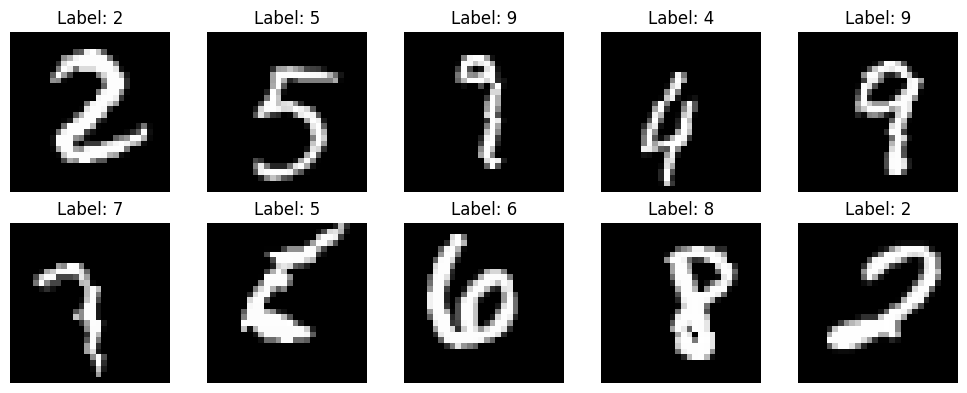

In [100]:
random_rotation = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Случайный поворот на [-10, +10] градусов
    transforms.ToTensor(),                 # Преобразование в тензор [1, 28, 28], [0.0, 1.0]
    transforms.Normalize((mean,), (std,))
])

no_rotation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

class Transformed_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        pass

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.dataset)

train_data_rotated = Transformed_Dataset(train_data, transform=random_rotation)
train_dataloader_rotated = torch.utils.data.DataLoader(train_data_rotated, batch_size=64, shuffle=True)

images, labels = next(iter(train_dataloader_rotated))

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')  # .squeeze() убирает канал [1, 28, 28] -> [28, 28]
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()